# Importing libraries: 

In [68]:
import numpy as np
import pandas as pd 
import seaborn as sns

# Importing Datasets

In [69]:
AS = pd.read_csv('../data/AirlineScrappedReview_Cleaned.csv')
CC = pd.read_csv('../data/Customer_comment.csv')
PB = pd.read_csv('../data/Passanger_booking_data.csv')
SS = pd.read_csv('../data/Survey data_Inflight Satisfaction Score.csv')

# Cleaning Customer Comment Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

<Axes: >

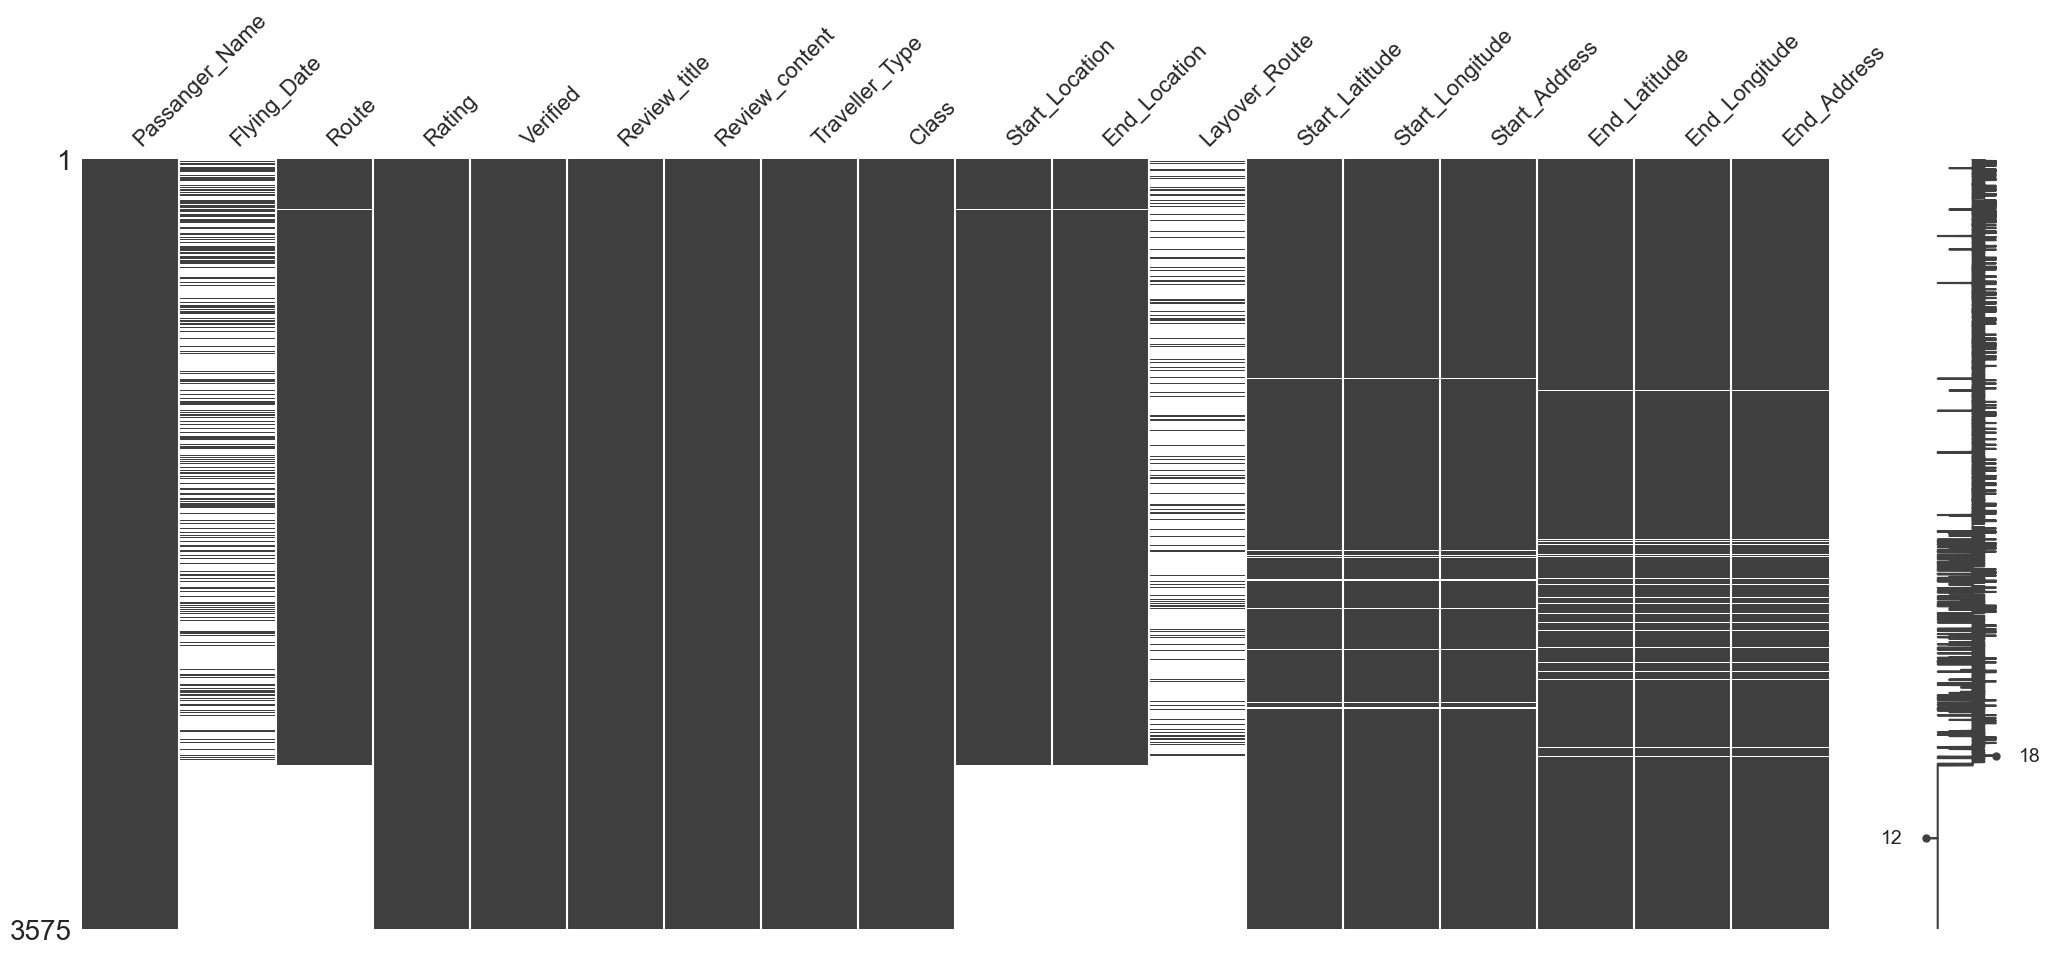

In [70]:

AS.head()
AS.info()
AS.describe()
AS.isnull().sum()
import missingno as msno
msno.matrix(AS)

C:\Users\mizon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mizon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mizon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mizon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarnin

Object dtypes (should be none): []
X shape: (3575, 19) | y shape: (3575,)


<Figure size 1200x500 with 0 Axes>

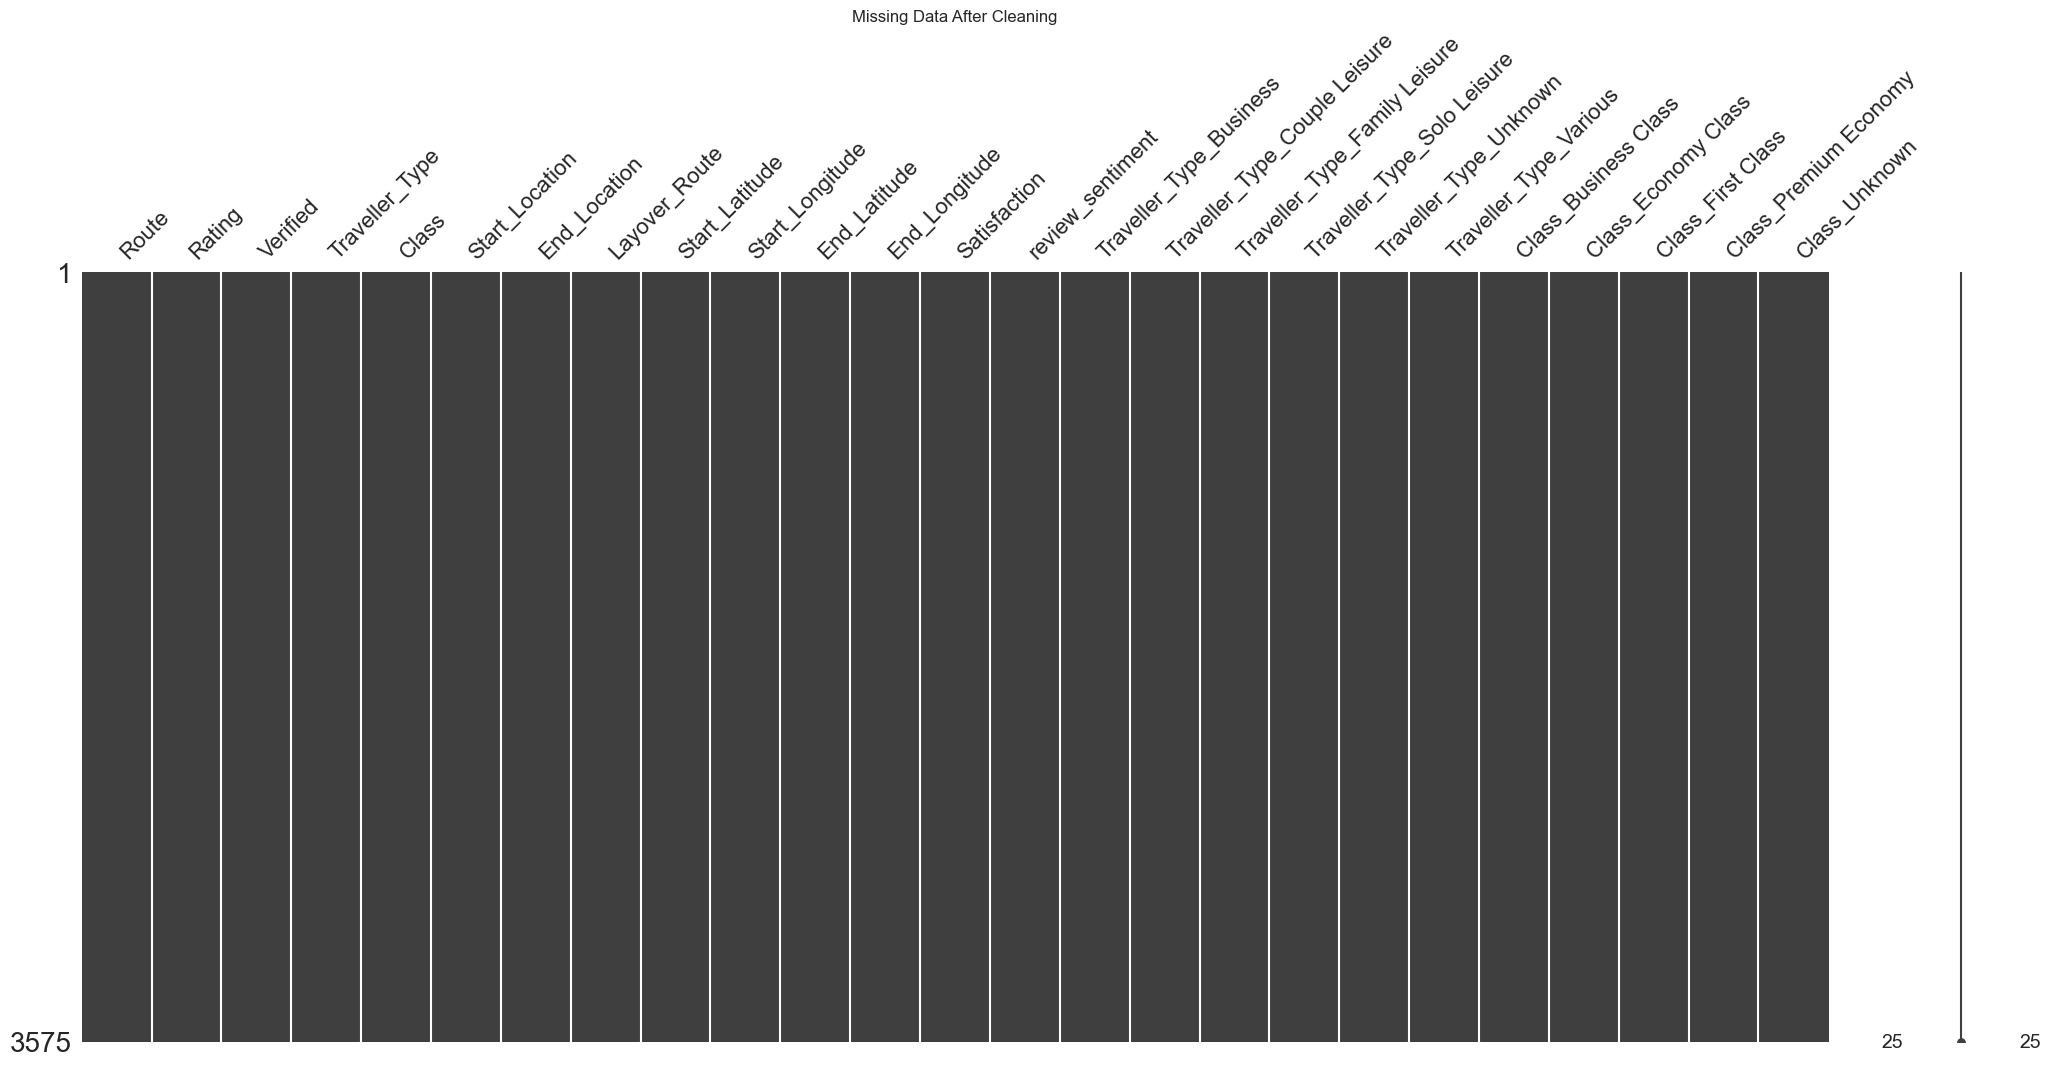

In [71]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# 1) Drop Flying_Date
AS.drop(columns=['Flying_Date'], inplace=True, errors='ignore')

# 2) Fill Start/End_Location from Addresses (assumed format: "Country, Address" → take first part)
def extract_country_first(address):
    if pd.isna(address) or not isinstance(address, str):
        return np.nan
    parts = [p.strip() for p in address.split(',') if p.strip()]
    return parts[0] if parts else np.nan

if {'Start_Location','Start_Address'}.issubset(AS.columns):
    mask_missing_start = AS['Start_Location'].isna() | (AS['Start_Location'].astype(str).str.strip()=='')
    AS.loc[mask_missing_start, 'Start_Location'] = AS.loc[mask_missing_start, 'Start_Address'].apply(extract_country_first)

if {'End_Location','End_Address'}.issubset(AS.columns):
    mask_missing_end = AS['End_Location'].isna() | (AS['End_Location'].astype(str).str.strip()=='')
    AS.loc[mask_missing_end, 'End_Location'] = AS.loc[mask_missing_end, 'End_Address'].apply(extract_country_first)

# 3) Rebuild Route as "Start_Location to End_Location"
if {'Start_Location','End_Location','Route'}.issubset(AS.columns) or {'Start_Location','End_Location'}.issubset(AS.columns):
    AS['Route'] = (
        AS['Start_Location'].astype(str).str.strip() +
        ' to ' +
        AS['End_Location'].astype(str).str.strip()
    )

# 4) Convert Layover_Route into binary 0/1 (KEEP SAME COLUMN NAME)
#    1 if there is any non-empty value (transit exists), else 0
if 'Layover_Route' in AS.columns:
    AS['Layover_Route'] = np.where(
        AS['Layover_Route'].astype(str).str.strip().replace({'nan':'', 'None':'', 'NaN':''}) != '',
        1, 0
    ).astype(int)

# 5) Optional neatness: strip + title-case key text columns
for col in ['Start_Location','End_Location','Route']:
    if col in AS.columns:
        AS[col] = AS[col].astype(str).str.strip().str.title()

# Rebuild Verified (0/1) robustly
if 'Verified' in AS.columns:
    v = (AS['Verified'].astype(str)
                    .str.lower()
                    .str.replace(r'[^a-z ]', '', regex=True)  # strip punctuation etc.
                    .str.strip())

    AS['Verified'] = v.map({
        'trip verified': 1,
        'verified': 1,
        'true': 1,
        'yes': 1,
        'not verified': 0,
        'unverified': 0,
        'false': 0,
        'no': 0,
        '': 0
    }).fillna(0).astype(int)


# 7) Create Satisfaction column (target variable)
if 'Rating' in AS.columns:
    AS['Satisfaction'] = np.where(AS['Rating'] >= 5, 1, 0)

# Fill Start_Latitude / Start_Longitude based on Start_Location median
for col in ['Start_Latitude', 'Start_Longitude']:
    if col in AS.columns:
        AS[col] = AS.groupby('Start_Location')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # If still missing, fill with global median
        AS[col].fillna(AS[col].median(), inplace=True)

# Do the same for End columns
for col in ['End_Latitude', 'End_Longitude']:
    if col in AS.columns:
        AS[col] = AS.groupby('End_Location')[col].transform(
            lambda x: x.fillna(x.median())
        )
        AS[col].fillna(AS[col].median(), inplace=True)

        # Fill missing Start_Address
if {'Start_Address','Start_Location'}.issubset(AS.columns):
    AS['Start_Address'] = AS.apply(
        lambda r: r['Start_Address']
        if pd.notna(r['Start_Address']) and str(r['Start_Address']).strip() != ''
        else f"Unknown Address, {r['Start_Location']}"
        if pd.notna(r['Start_Location'])
        else "Unknown Address",
        axis=1
    )

# Fill missing End_Address
if {'End_Address','End_Location'}.issubset(AS.columns):
    AS['End_Address'] = AS.apply(
        lambda r: r['End_Address']
        if pd.notna(r['End_Address']) and str(r['End_Address']).strip() != ''
        else f"Unknown Address, {r['End_Location']}"
        if pd.notna(r['End_Location'])
        else "Unknown Address",
        axis=1
    )


for col in ['Start_Address','End_Address']:
    AS[col] = AS[col].astype(str).str.strip().str.title()

# Remove impossible coordinates (out of range)
AS.loc[~AS['Start_Latitude'].between(-90,90), 'Start_Latitude'] = np.nan
AS.loc[~AS['End_Latitude'].between(-90,90), 'End_Latitude'] = np.nan
AS.loc[~AS['Start_Longitude'].between(-180,180), 'Start_Longitude'] = np.nan
AS.loc[~AS['End_Longitude'].between(-180,180), 'End_Longitude'] = np.nan

cols_to_drop = ['Passanger_Name', 'Review_title', 'Start_Address', 'End_Address']
AS.drop(columns=[c for c in cols_to_drop if c in AS.columns], inplace=True, errors='ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
if 'Review_content' in AS.columns:
    AS['review_sentiment'] = AS['Review_content'].fillna('').astype(str)\
        .apply(lambda t: analyzer.polarity_scores(t)['compound'])
else:
    AS['review_sentiment'] = 0.0  # fallback if column missing

AS.drop(columns=['Review_content'], inplace=True, errors='ignore')

ohe_cols = [c for c in ['Traveller_Type','Class'] if c in AS.columns]
dummies = pd.get_dummies(AS[ohe_cols], prefix=ohe_cols, drop_first=False)
AS = pd.concat([AS, dummies], axis=1)


# Example if you decide to do it later:
# AS = ohe_top_n(AS, 'Start_Location', top_n=25)
# AS = ohe_top_n(AS, 'End_Location', top_n=25)
# AS = ohe_top_n(AS, 'Route', top_n=50)


# Target
y = AS['Satisfaction'].astype(int)

# Base numeric features
base_num = [c for c in [
    'Rating','Verified','Layover_Route',
    'Start_Latitude','Start_Longitude','End_Latitude','End_Longitude',
    'review_sentiment'
] if c in AS.columns]

# OHE features (added above)
ohe_feats = [c for c in AS.columns if c.startswith('Traveller_Type_') or c.startswith('Class_')]

# Final feature set
X = AS[base_num + ohe_feats].copy()

# Safety: fill any remaining NaNs
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce').fillna(X[c].median())


print("Object dtypes (should be none):", list(X.select_dtypes(include='object').columns))
print("X shape:", X.shape, "| y shape:", y.shape)

bool_cols = AS.select_dtypes(include=['bool']).columns
AS[bool_cols] = AS[bool_cols].astype(int)



# --- Visualize missingness after cleaning ---
plt.figure(figsize=(12,5))
msno.matrix(AS)
plt.title("Missing Data After Cleaning")
plt.show()

In [72]:
AS.head()

,Route,Rating,Verified,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,...,Traveller_Type_Couple Leisure,Traveller_Type_Family Leisure,Traveller_Type_Solo Leisure,Traveller_Type_Unknown,Traveller_Type_Various,Class_Business Class,Class_Economy Class,Class_First Class,Class_Premium Economy,Class_Unknown
0,New Orleans To London,1,1,Solo Leisure,Economy Class,New Orleans,London,0,29.975998,-90.078213,...,0,0,1,0,0,0,1,0,0,0
1,London To Amman,1,1,Couple Leisure,Business Class,London,Amman,0,51.507446,-0.127765,...,1,0,0,0,0,1,0,0,0,0
2,London Heathrow To Bodrum,2,1,Solo Leisure,Business Class,London Heathrow,Bodrum,0,51.467739,-0.458780,...,0,0,1,0,0,1,0,0,0,0
3,Amman To London,4,0,Solo Leisure,Economy Class,Amman,London,0,31.951569,35.923963,...,0,0,1,0,0,0,1,0,0,0
4,London City To Ibiza,7,1,Family Leisure,Business Class,London City,Ibiza,0,42.953765,-81.229153,...,0,1,0,0,0,1,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

<Axes: >

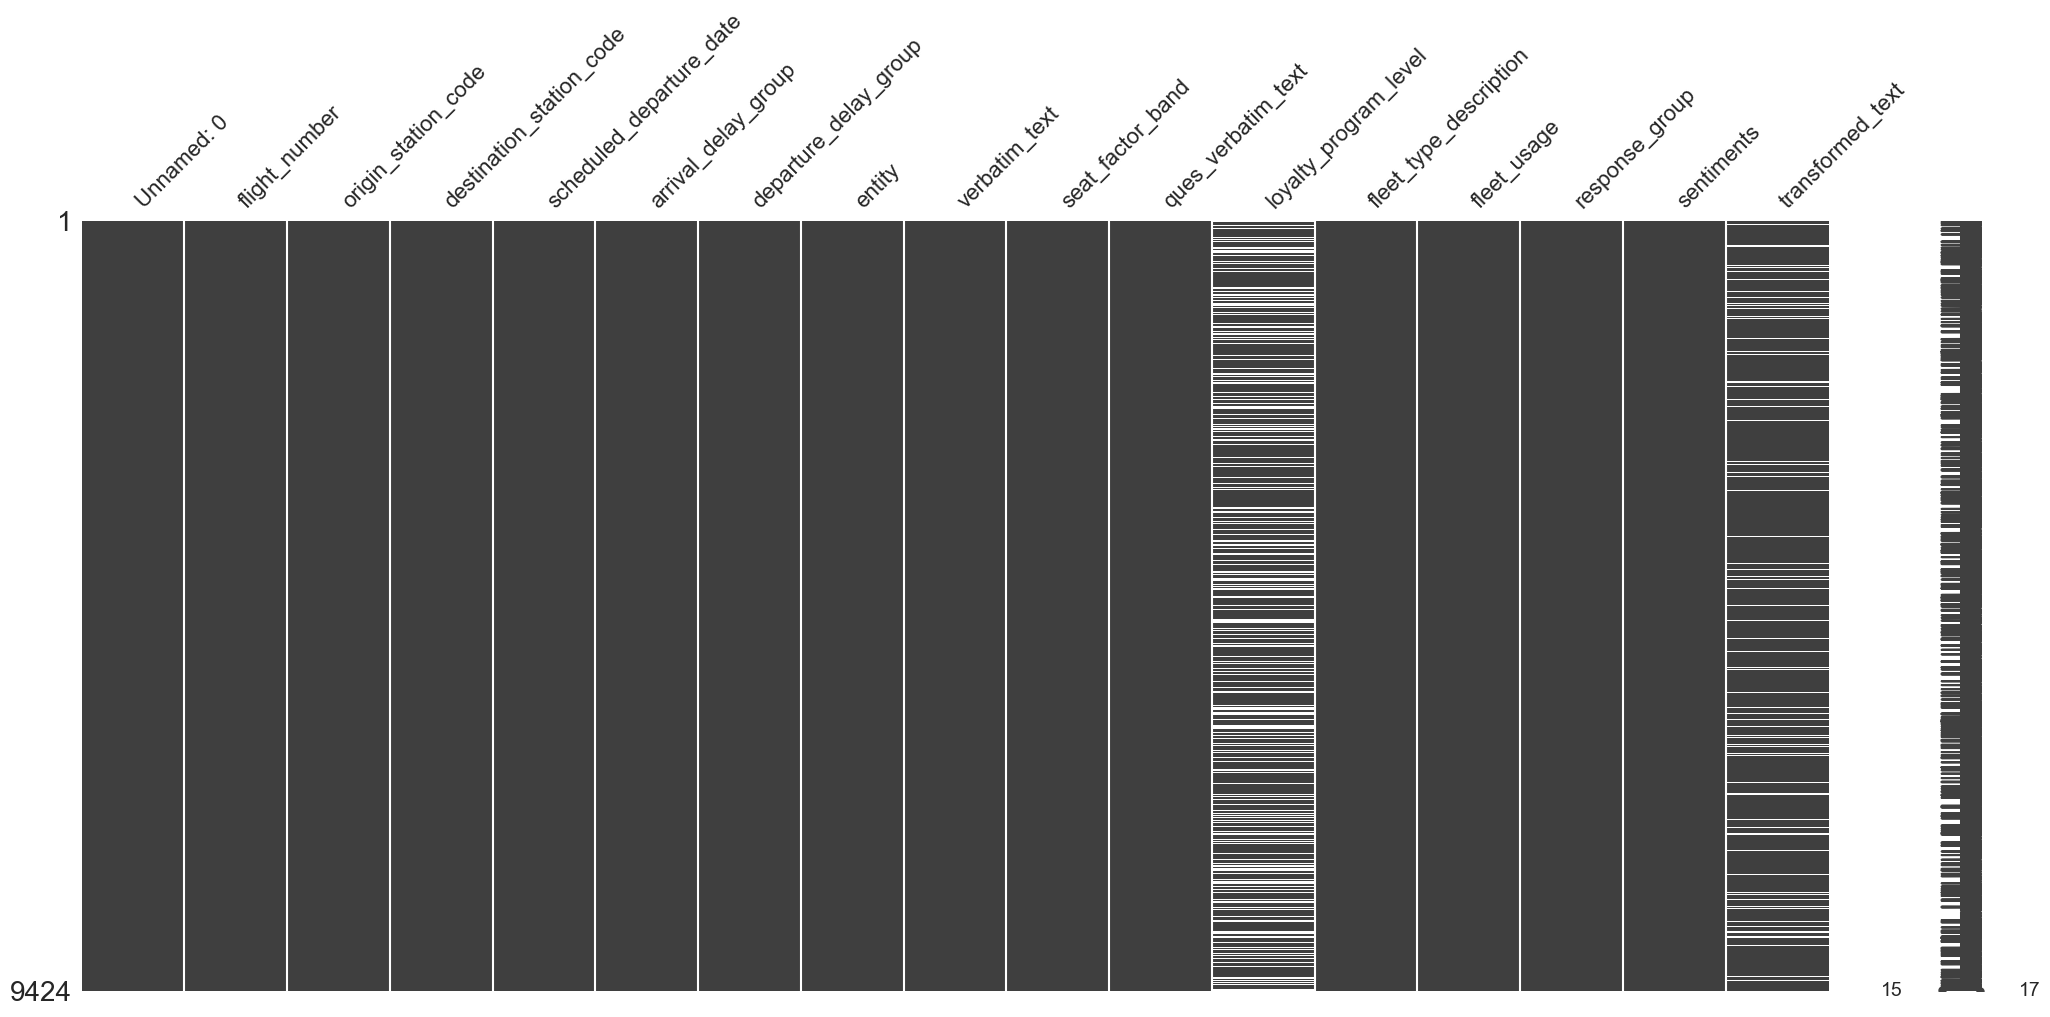

In [73]:
CC.info()
CC.describe()
CC.isnull().sum()
import missingno as msno
msno.matrix(CC)

In [74]:
#drop duplicastes
CC = CC.drop(columns=['Unnamed: 0'])
CC = CC.drop_duplicates()
#Null values
CC['transformed_text'] = CC['transformed_text'].fillna('')
CC['loyalty_program_level'] = CC['loyalty_program_level'].fillna('Unknown')
#dates
CC['scheduled_departure_date'] = pd.to_datetime(CC['scheduled_departure_date'], errors='coerce')
CC['month'] = CC['scheduled_departure_date'].dt.month
CC['day_of_week'] = CC['scheduled_departure_date'].dt.dayofweek

Balls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

<Axes: >

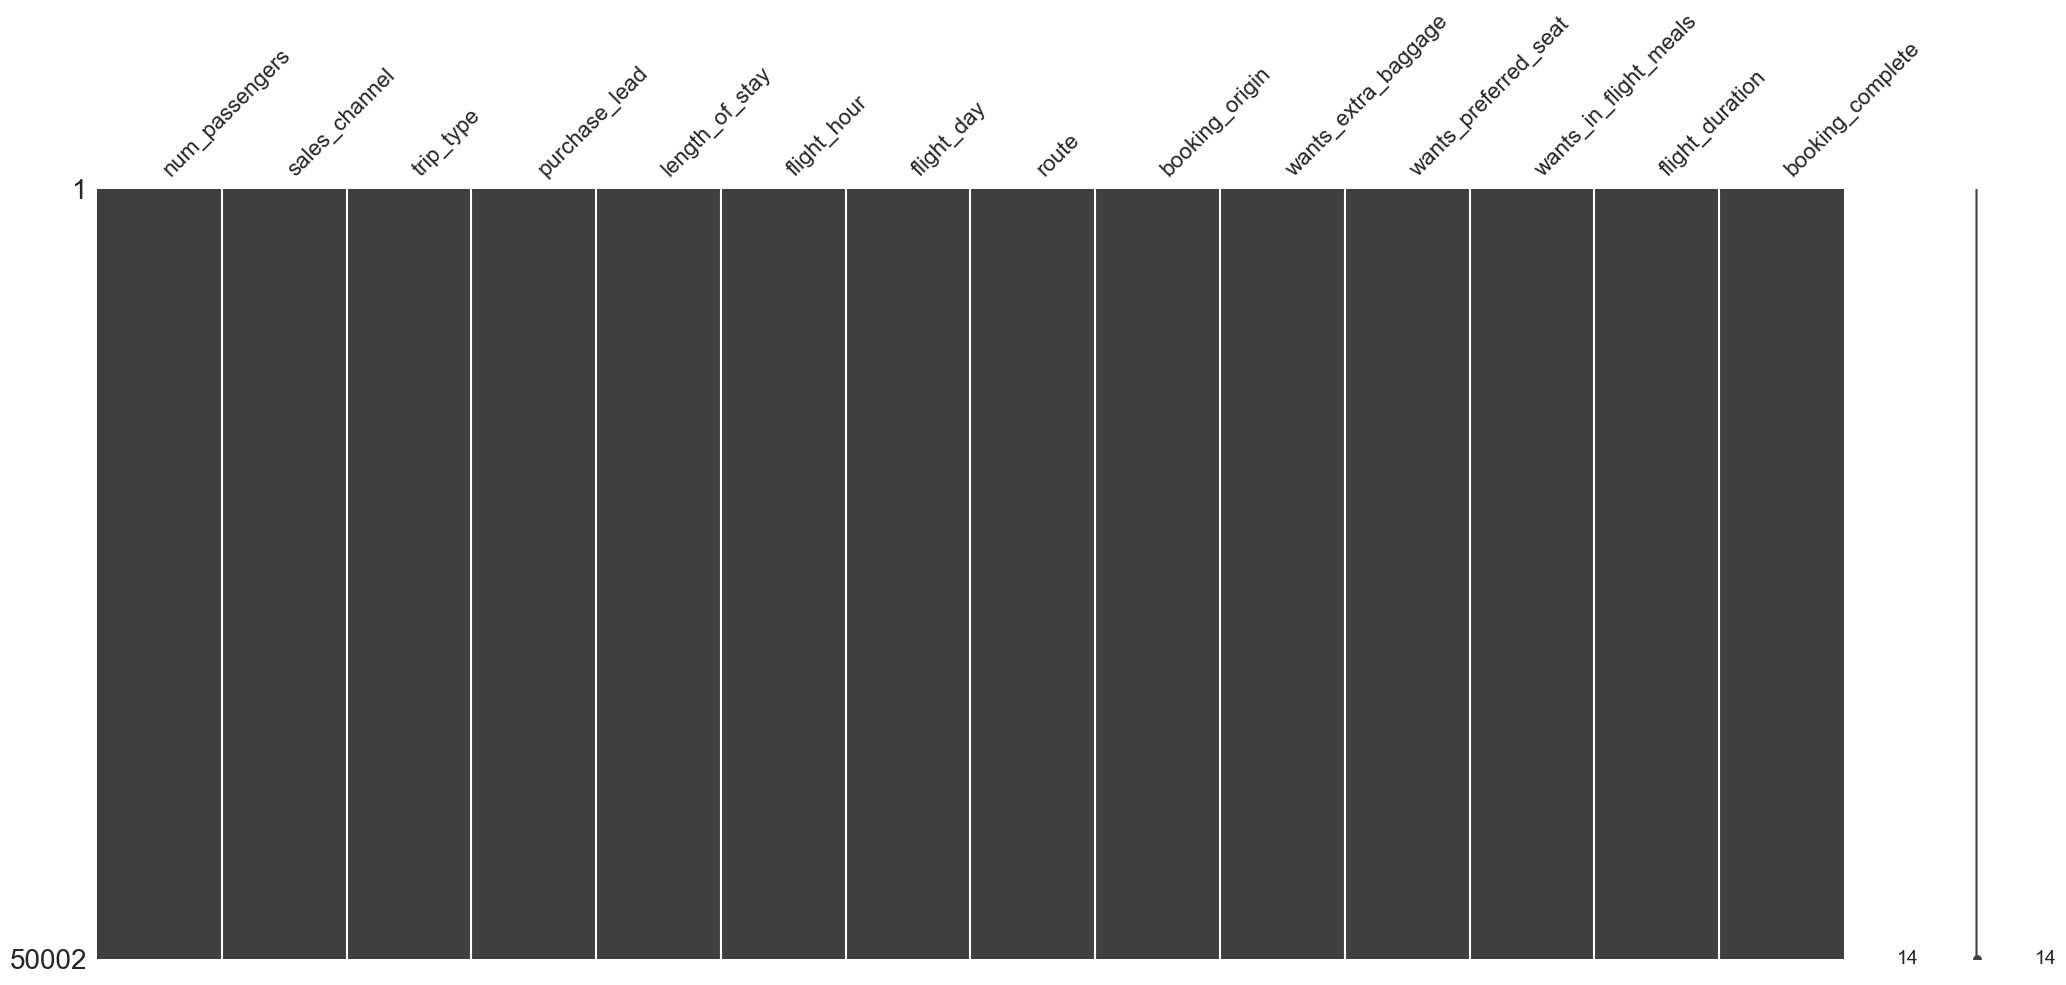

In [75]:
PB.info()
PB.describe()
PB.isnull().sum()
import missingno as msno
msno.matrix(PB)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

<Axes: >

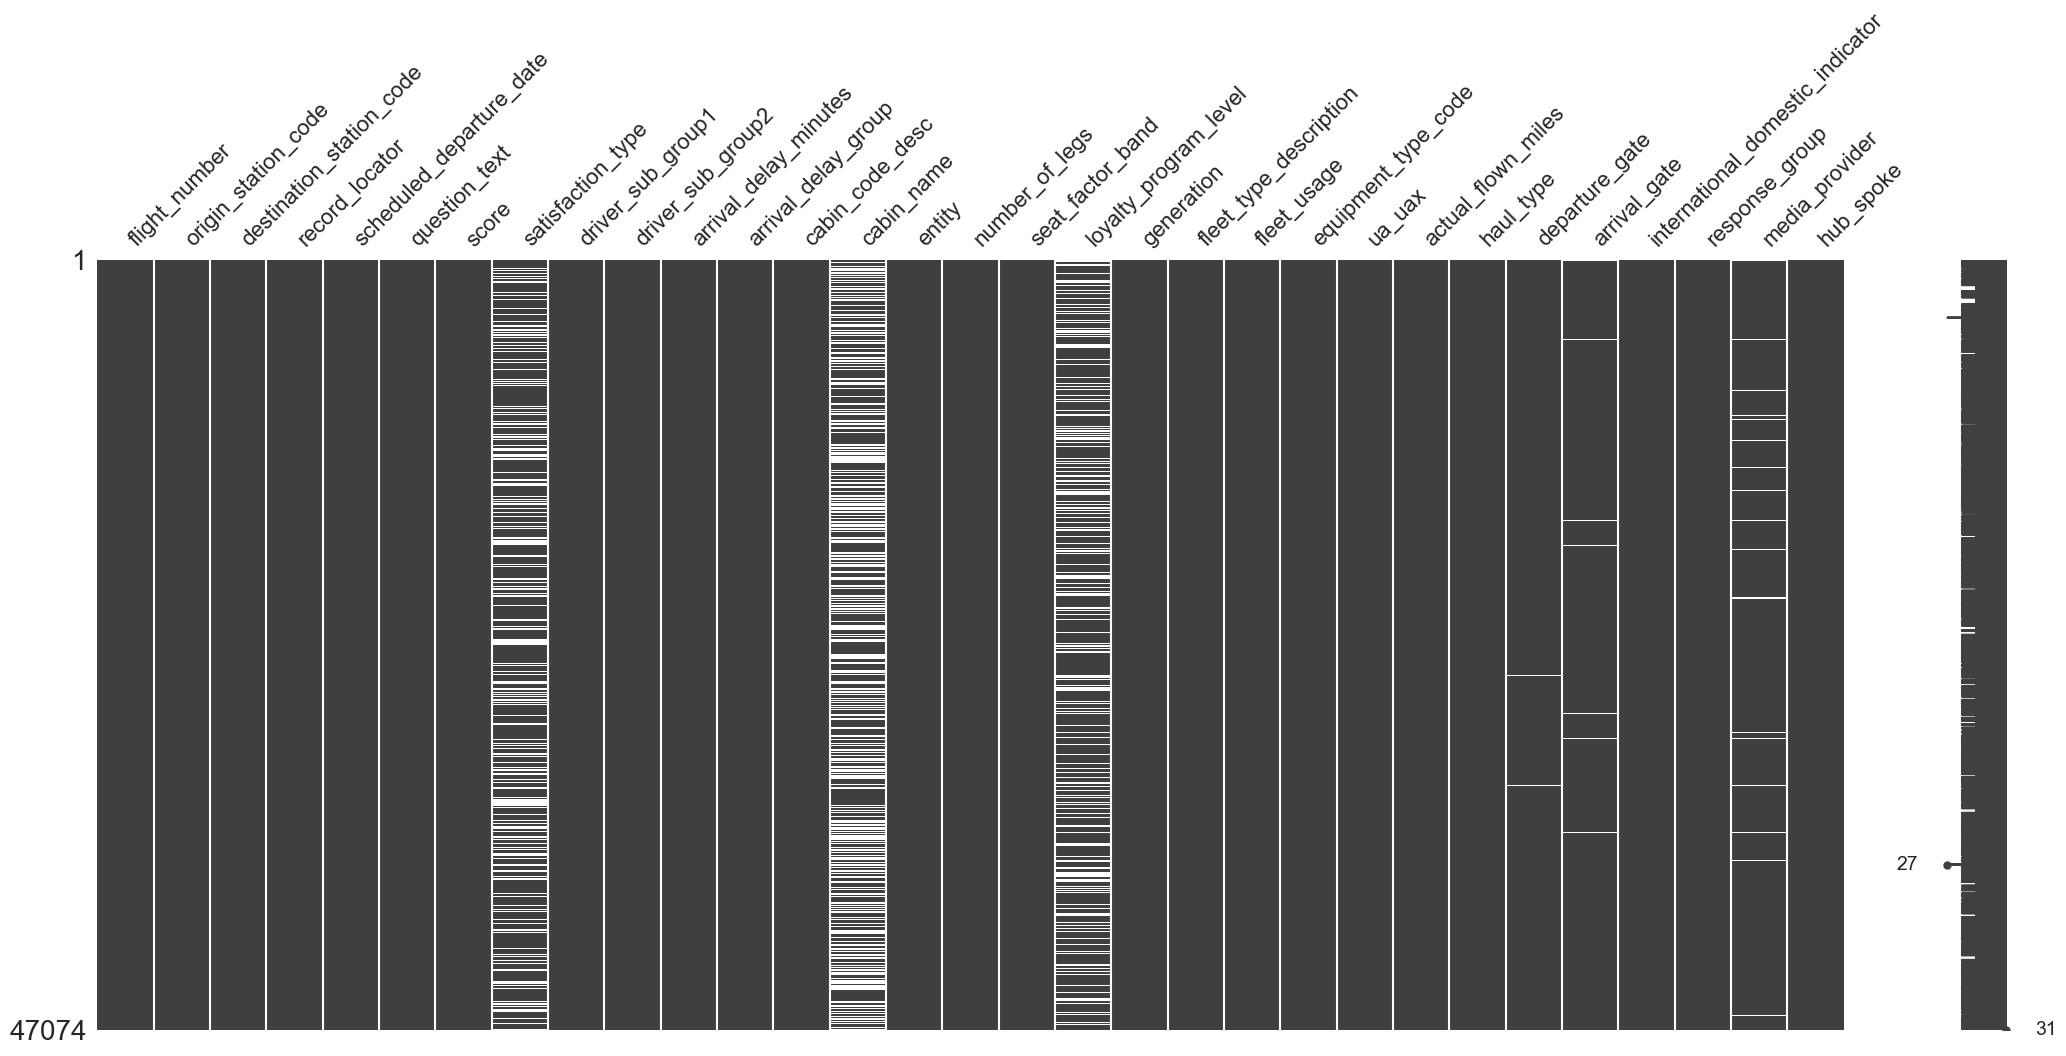

In [76]:
SS.info()
SS.describe()
SS.isnull().sum()
import missingno as msno
msno.matrix(SS)

Research Question

In [77]:

# ✈️ Airline Booking Analysis (Fixed Version)
# -------------------------------------------
# Answers:
# 1. What are the top 10 most popular flight routes?
# 2. What is the distribution of bookings across flight hours?



# --- 1. Top 10 Most Popular Flight Routes ---
top_routes = (
    PB['route']
    .value_counts()
    .head(10)
    .reset_index()
)
top_routes.columns = ['Route', 'Booking_Count']  # <-- safer column rename

# --- 2. Distribution of Bookings Across Flight Hours ---
flight_hour_distribution = (
    PB['flight_hour']
    .value_counts()
    .sort_index()
    .reset_index()
)
flight_hour_distribution.columns = ['Flight_Hour', 'Booking_Count']

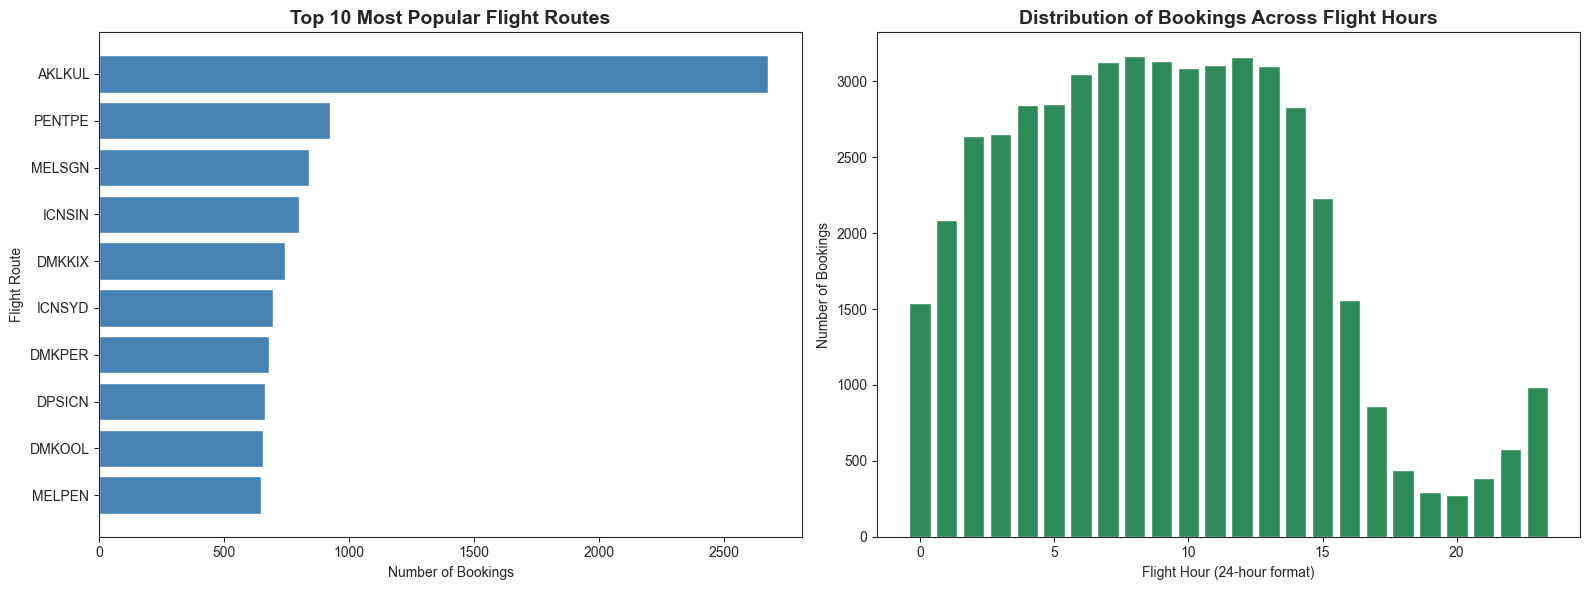


 Top 10 Most Popular Routes:
    Route  Booking_Count
0  AKLKUL           2680
1  PENTPE            924
2  MELSGN            842
3  ICNSIN            801
4  DMKKIX            744
5  ICNSYD            695
6  DMKPER            679
7  DPSICN            666
8  DMKOOL            655
9  MELPEN            649

 Distribution of Bookings Across Flight Hours:
    Flight_Hour  Booking_Count
0             0           1539
1             1           2089
2             2           2642
3             3           2655
4             4           2843
5             5           2851
6             6           3051
7             7           3126
8             8           3165
9             9           3133
10           10           3085
11           11           3110
12           12           3163
13           13           3101
14           14           2833
15           15           2234
16           16           1557
17           17            861
18           18            439
19           19            

In [78]:
# --- Visualization ---

sns.set_style("ticks")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top 10 Routes
axes[0].barh(top_routes['Route'], top_routes['Booking_Count'], color='steelblue')
axes[0].set_title('Top 10 Most Popular Flight Routes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Bookings')
axes[0].set_ylabel('Flight Route')
axes[0].invert_yaxis()

# Plot 2: Bookings Across Flight Hours
axes[1].bar(flight_hour_distribution['Flight_Hour'], flight_hour_distribution['Booking_Count'], color='seagreen')
axes[1].set_title('Distribution of Bookings Across Flight Hours', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Flight Hour (24-hour format)')
axes[1].set_ylabel('Number of Bookings')

plt.tight_layout()
plt.show()

# --- Print results ---
print("\n Top 10 Most Popular Routes:")
print(top_routes)

print("\n Distribution of Bookings Across Flight Hours:")
print(flight_hour_distribution.head(24))


In [79]:
print(AS.columns.tolist())

['Route', 'Rating', 'Verified', 'Traveller_Type', 'Class', 'Start_Location', 'End_Location', 'Layover_Route', 'Start_Latitude', 'Start_Longitude', 'End_Latitude', 'End_Longitude', 'Satisfaction', 'review_sentiment', 'Traveller_Type_Business', 'Traveller_Type_Couple Leisure', 'Traveller_Type_Family Leisure', 'Traveller_Type_Solo Leisure', 'Traveller_Type_Unknown', 'Traveller_Type_Various', 'Class_Business Class', 'Class_Economy Class', 'Class_First Class', 'Class_Premium Economy', 'Class_Unknown']


In [80]:
# 🧭 Airline Review Sentiment Analysis
# -----------------------------------
# Question:
# → Which traveler type and class combination yields the highest and lowest ratings?



# --- Ensure Rating is numeric ---
AS['Rating'] = pd.to_numeric(AS['Rating'], errors='coerce')

# --- Group by Traveler Type and Class ---
rating_summary = (
    AS.groupby(['Traveller_Type', 'Class'], dropna=False)['Rating']
    .mean()
    .reset_index()
    .sort_values(by='Rating', ascending=False)
)



🌟 Highest Rated Combination:
Traveller_Type       Class   Rating
       Unknown First Class 7.127273

💔 Lowest Rated Combination:
Traveller_Type         Class  Rating
       Various Economy Class     1.0


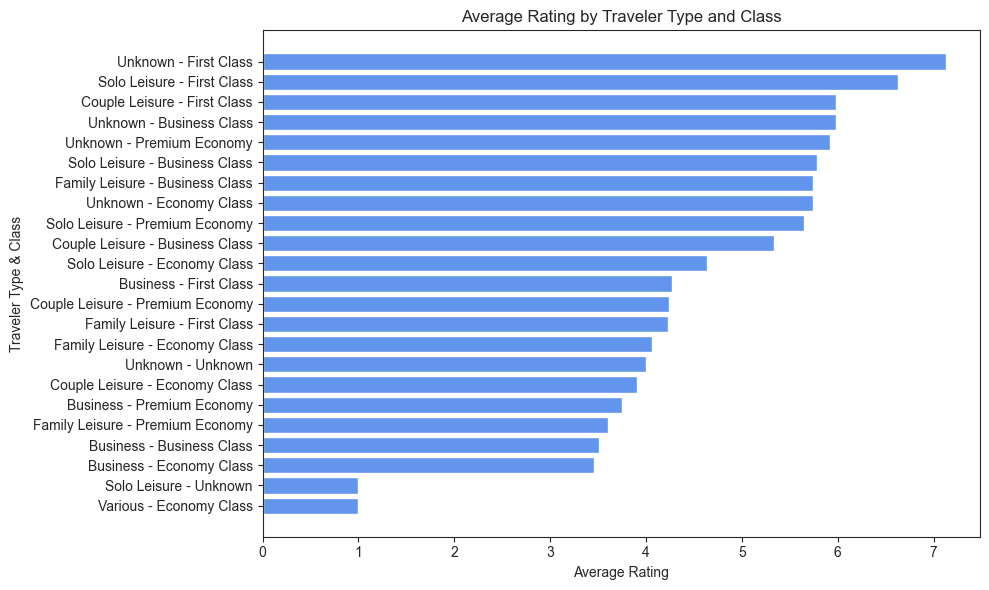


📊 Average Ratings by Traveler Type and Class:
    Traveller_Type            Class    Rating
19         Unknown      First Class  7.127273
14    Solo Leisure      First Class  6.627907
6   Couple Leisure      First Class  5.983607
17         Unknown   Business Class  5.982935
20         Unknown  Premium Economy  5.919540
12    Solo Leisure   Business Class  5.780347
8   Family Leisure   Business Class  5.743902
18         Unknown    Economy Class  5.740741
15    Solo Leisure  Premium Economy  5.653061
4   Couple Leisure   Business Class  5.332335
13    Solo Leisure    Economy Class  4.631193
2         Business      First Class  4.270270
7   Couple Leisure  Premium Economy  4.239583
10  Family Leisure      First Class  4.230769
9   Family Leisure    Economy Class  4.061069
21         Unknown          Unknown  4.000000
5   Couple Leisure    Economy Class  3.908297
3         Business  Premium Economy  3.750000
11  Family Leisure  Premium Economy  3.600000
0         Business   Business Cla

In [81]:
# --- Identify the best and worst combinations ---
highest = rating_summary.head(1)
lowest = rating_summary.tail(1)

print("🌟 Highest Rated Combination:")
print(highest.to_string(index=False))
print("\n💔 Lowest Rated Combination:")
print(lowest.to_string(index=False))

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.barh(
    rating_summary['Traveller_Type'] + " - " + rating_summary['Class'],
    rating_summary['Rating'],
    color='cornflowerblue'
)
plt.xlabel("Average Rating")
plt.ylabel("Traveler Type & Class")
plt.title("Average Rating by Traveler Type and Class")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Optional: Display summary table ---
print("\n📊 Average Ratings by Traveler Type and Class:")
print(rating_summary)


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers, optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# (optional) reproducibility
tf.random.set_seed(42)

In [83]:
num_feats = [
    'Verified','Layover_Route',
    'Start_Latitude','Start_Longitude','End_Latitude','End_Longitude',
    'review_sentiment'
]
ohe_feats = [c for c in AS.columns if c.startswith('Traveller_Type_') or c.startswith('Class_')]
X = AS[num_feats + ohe_feats]
y = AS['Satisfaction'].astype(int)

# Split once
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Make copies
X_train_std = X_train.copy()
X_val_std   = X_val.copy()
X_train_mm  = X_train.copy()
X_val_mm    = X_val.copy()

# Scale numeric columns differently
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

X_train_std[num_feats] = sc_std.fit_transform(X_train[num_feats])
X_val_std[num_feats]   = sc_std.transform(X_val[num_feats])

X_train_mm[num_feats] = sc_mm.fit_transform(X_train[num_feats])
X_val_mm[num_feats]   = sc_mm.transform(X_val[num_feats])

In [84]:
tf.random.set_seed(42)

# ----- Model 1A: STD + ReLU (baseline) -----
model1A = Sequential([
    layers.Input(shape=(X_train_std.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model1A.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history1A = model1A.fit(
    X_train_std, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6455 - loss: 0.6446 - precision: 0.6709 - recall: 0.4889 - val_accuracy: 0.7343 - val_loss: 0.5975 - val_precision: 0.7600 - val_recall: 0.7085
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.5511 - precision: 0.7312 - recall: 0.7583 - val_accuracy: 0.7797 - val_loss: 0.5161 - val_precision: 0.7632 - val_recall: 0.8305
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7771 - loss: 0.4916 - precision: 0.7367 - recall: 0.8213 - val_accuracy: 0.7815 - val_loss: 0.4890 - val_precision: 0.7640 - val_recall: 0.8339
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7837 - loss: 0.4714 - precision: 0.7423 - recall: 0.8296 - val_accuracy: 0.7885 - val_loss: 0.4832 - val_precision: 0.7719 - val_recall: 0.8373
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7885 - loss: 0.4632 - precision: 0.7508 - recall: 0.8259 - val_accuracy: 0.7867 - val_loss: 0.4809 - va

In [85]:
tf.random.set_seed(42)

# ----- Model 1B: STD + Wider + Dropout + L2 + lower LR -----
model1B = Sequential([
    layers.Input(shape=(X_train_std.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.30),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(1, activation='sigmoid')
])

model1B.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

history1B = model1B.fit(
    X_train_std, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6206 - loss: 0.6743 - precision: 0.7598 - recall: 0.2870 - val_accuracy: 0.7622 - val_loss: 0.6087 - val_precision: 0.7641 - val_recall: 0.7797
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.5682 - precision: 0.7429 - recall: 0.7065 - val_accuracy: 0.7902 - val_loss: 0.5289 - val_precision: 0.7778 - val_recall: 0.8305
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7727 - loss: 0.5080 - precision: 0.7504 - recall: 0.7769 - val_accuracy: 0.7955 - val_loss: 0.4981 - val_precision: 0.7764 - val_recall: 0.8475
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7845 - loss: 0.4844 - precision: 0.7502 - recall: 0.8148 - val_accuracy: 0.7955 - val_loss: 0.4917 - val_precision: 0.7747 - val_recall: 0.8508
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7902 - loss: 0.4800 - precision: 0.7547 - recall: 0.8231 - val_accuracy: 0.7972 - val_loss: 0.4892 - val

In [86]:
tf.random.set_seed(42)

# ----- Model 2A: MinMax + tanh -----
model2A = Sequential([
    layers.Input(shape=(X_train_mm.shape[1],)),
    layers.Dense(16, activation='tanh'),
    layers.Dense(8, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

model2A.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history2A = model2A.fit(
    X_train_mm, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5638 - loss: 0.6869 - precision: 0.5360 - recall: 0.5657 - val_accuracy: 0.6381 - val_loss: 0.6369 - val_precision: 0.6183 - val_recall: 0.7797
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7190 - loss: 0.5922 - precision: 0.6956 - recall: 0.7194 - val_accuracy: 0.7465 - val_loss: 0.5720 - val_precision: 0.7206 - val_recall: 0.8305
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7596 - loss: 0.5305 - precision: 0.7366 - recall: 0.7639 - val_accuracy: 0.7710 - val_loss: 0.5251 - val_precision: 0.7531 - val_recall: 0.8271
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.4895 - precision: 0.7507 - recall: 0.7889 - val_accuracy: 0.7937 - val_loss: 0.4976 - val_precision: 0.7827 - val_recall: 0.8305
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7880 - loss: 0.4681 - precision: 0.7571 - recall: 0.8111 - val_accuracy: 0.8024 - val_loss: 0.4865 - val

In [87]:
tf.random.set_seed(42)

# ----- Model 2B: MinMax + BatchNorm + ReLU + Dropout -----
model2B = Sequential([
    layers.Input(shape=(X_train_mm.shape[1],)),
    layers.Dense(32, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.20),

    layers.Dense(16, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1, activation='sigmoid')
])

model2B.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

history2B = model2B.fit(
    X_train_mm, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5402 - loss: 0.7388 - precision: 0.5128 - recall: 0.5185 - val_accuracy: 0.6556 - val_loss: 0.6528 - val_precision: 0.6713 - val_recall: 0.6508
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 0.5811 - precision: 0.6938 - recall: 0.6463 - val_accuracy: 0.7343 - val_loss: 0.5909 - val_precision: 0.7619 - val_recall: 0.7051
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7531 - loss: 0.5294 - precision: 0.7436 - recall: 0.7278 - val_accuracy: 0.7745 - val_loss: 0.5355 - val_precision: 0.7767 - val_recall: 0.7898
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7570 - loss: 0.5089 - precision: 0.7462 - recall: 0.7352 - val_accuracy: 0.7937 - val_loss: 0.5030 - val_precision: 0.7792 - val_recall: 0.8373
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7780 - loss: 0.4938 - precision: 0.7577 - recall: 0.7787 - val_accuracy: 0.8042 - val_loss: 0.4868 - val

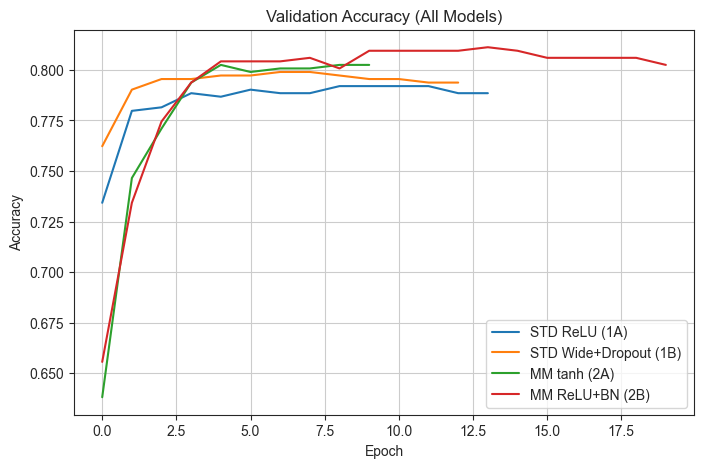

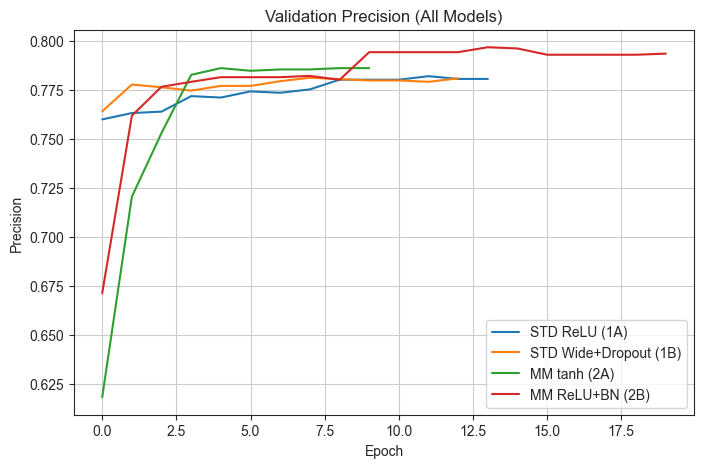

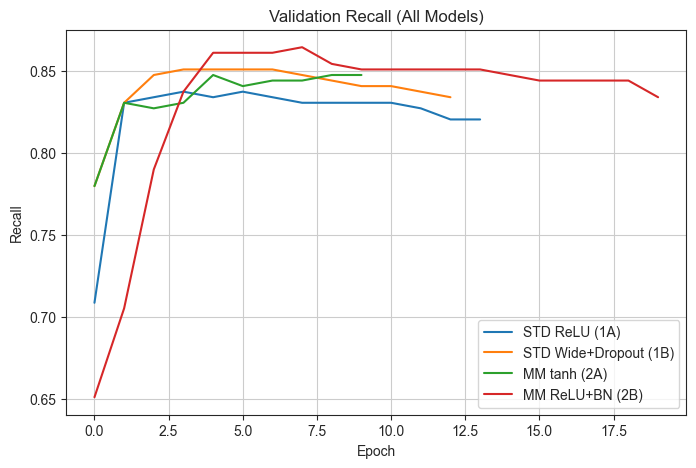

In [88]:
import matplotlib.pyplot as plt

# --- Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(history1A.history['val_accuracy'], label='STD ReLU (1A)')
plt.plot(history1B.history['val_accuracy'], label='STD Wide+Dropout (1B)')
plt.plot(history2A.history['val_accuracy'], label='MM tanh (2A)')
plt.plot(history2B.history['val_accuracy'], label='MM ReLU+BN (2B)')
plt.title('Validation Accuracy (All Models)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Precision ---
plt.figure(figsize=(8, 5))
plt.plot(history1A.history['val_precision'], label='STD ReLU (1A)')
plt.plot(history1B.history['val_precision'], label='STD Wide+Dropout (1B)')
plt.plot(history2A.history['val_precision'], label='MM tanh (2A)')
plt.plot(history2B.history['val_precision'], label='MM ReLU+BN (2B)')
plt.title('Validation Precision (All Models)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# --- Recall ---
plt.figure(figsize=(8, 5))
plt.plot(history1A.history['val_recall'], label='STD ReLU (1A)')
plt.plot(history1B.history['val_recall'], label='STD Wide+Dropout (1B)')
plt.plot(history2A.history['val_recall'], label='MM tanh (2A)')
plt.plot(history2B.history['val_recall'], label='MM ReLU+BN (2B)')
plt.title('Validation Recall (All Models)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
from sklearn.metrics import f1_score

# 1A
y_pred_1A = (model1A.predict(X_val_std) > 0.5).astype(int)
print("Model 1A F1:", f1_score(y_val, y_pred_1A))

# 1B
y_pred_1B = (model1B.predict(X_val_std) > 0.5).astype(int)
print("Model 1B F1:", f1_score(y_val, y_pred_1B))

# 2A
y_pred_2A = (model2A.predict(X_val_mm) > 0.5).astype(int)
print("Model 2A F1:", f1_score(y_val, y_pred_2A))

# 2B
y_pred_2B = (model2B.predict(X_val_mm) > 0.5).astype(int)
print("Model 2B F1:", f1_score(y_val, y_pred_2B))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 1A F1: 0.8285322359396433
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 1B F1: 0.8224043715846995
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model 2A F1: 0.8246575342465754
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model 2B F1: 0.8275862068965517


In [91]:
model = model1A

PermutationExplainer explainer: 201it [00:29,  6.70it/s]                         
C:\Users\mizon\AppData\Local\Temp\ipykernel_29204\196451428.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_std.iloc[:200], plot_type="bar", show=False)
C:\Users\mizon\AppData\Local\Temp\ipykernel_29204\196451428.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_std.iloc[:200], show=False)


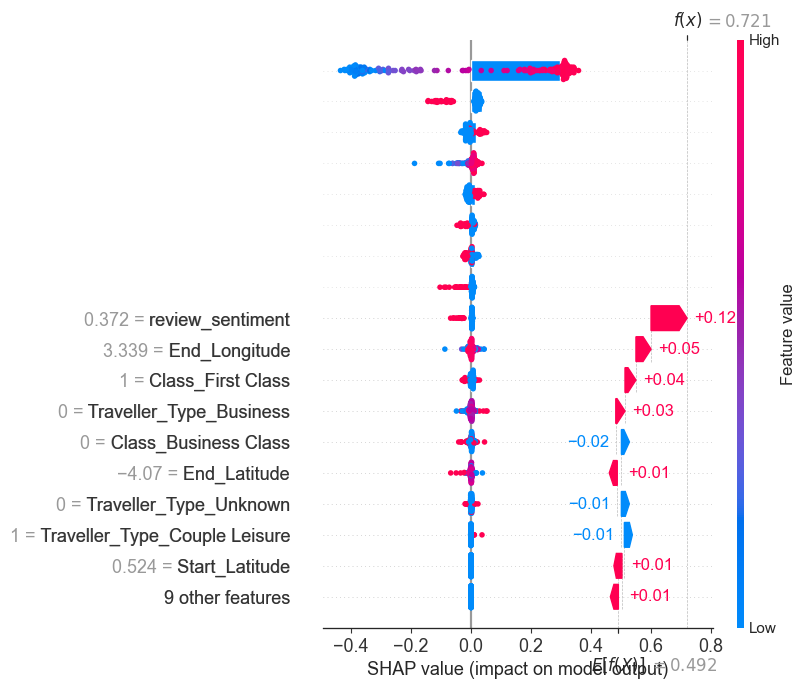

In [92]:
import shap
import numpy as np

# Explain using SHAP DeepExplainer
explainer = shap.Explainer(model, X_train_std, feature_names=X_train_std.columns)
shap_values = explainer(X_val_std[:200])  # Use subset for speed

# --- Global Importance ---
shap.summary_plot(shap_values, X_val_std.iloc[:200], plot_type="bar", show=False)

# --- Detailed Beeswarm Plot ---
shap.summary_plot(shap_values, X_val_std.iloc[:200], show=False)

# --- Single Prediction Explanation (local) ---
idx = 5  # choose any sample index
shap.plots.waterfall(shap_values[idx])


PermutationExplainer explainer: 716it [00:57, 10.25it/s]                         
C:\Users\mizon\AppData\Local\Temp\ipykernel_29204\3288232890.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_val_std, feature_names=X_val_std.columns, plot_type='bar')


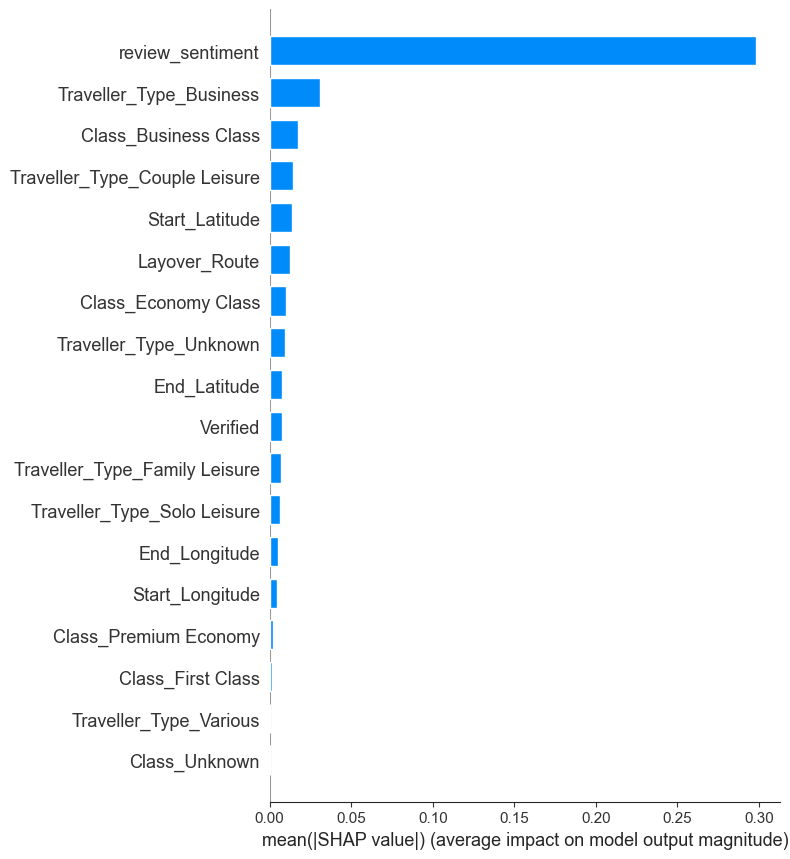

In [101]:
# Initialize SHAP JS visuals
shap.initjs()

# Wrap your model prediction function
def predict_fn(X):
    return model.predict(X)
# Select a background (reference) dataset for SHAP
background = shap.sample(X_train_std, 100, random_state=42)

# Create the SHAP Explainer (auto-selects best explainer for model type)
explainer = shap.Explainer(model, background)

# Compute SHAP values using the standardized validation set
shap_values = explainer(X_val_std)

# ==== GLOBAL SUMMARY PLOT ====
shap.summary_plot(shap_values.values, X_val_std, feature_names=X_val_std.columns, plot_type='bar')

# ==== LOCAL EXPLANATION (first sample example) ====
i = 420
shap.plots.force(shap_values[i])

In [100]:
import numpy as np
import lime
import lime.lime_tabular

# Wrap Keras predict to behave like predict_proba
def keras_predict_proba(x):
    preds = model.predict(x)
    if preds.ndim == 1 or preds.shape[1] == 1:  # binary case (sigmoid)
        preds = np.hstack([1 - preds, preds])
    return preds

# Initialize LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_std.values,
    feature_names=X_train_std.columns,
    class_names=['Not Satisfied', 'Satisfied'],
    discretize_continuous=True
)

# Explain one instance
i = 67
exp = explainer_lime.explain_instance(
    X_val_std.values[i],
    keras_predict_proba,
    num_features=6
)

from IPython.display import HTML
display(HTML(exp.as_html()))




157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
